## Model Training

#### Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings

#### Import the CSV data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/StudentsPerformance.csv')
df.shape

(1000, 8)

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

#### Show the first 5 records of the dataset

In [4]:
df.head().T

,0,1,2,3,4
gender,female,female,female,male,male
race_ethnicity,group B,group C,group B,group A,group C
parental_level_of_education,bachelor's degree,some college,master's degree,associate's degree,some college
lunch,standard,standard,standard,free/reduced,standard
test_preparation_course,none,completed,none,none,none
math_score,72,69,90,47,76
reading_score,72,90,95,57,78
writing_score,74,88,93,44,75


#### Prepare the $X$ feature matrix and the $y$ target variable

In [5]:
# Separate dataset into train, validation and test
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.math_score.values
y_val = df_val.math_score.values
y_test = df_test.math_score.values

del df_train['math_score']
del df_val['math_score']
del df_test['math_score']

In [6]:
df_train.head().T

,0,1,2,3,4
gender,male,male,male,male,male
race_ethnicity,group D,group C,group C,group E,group B
parental_level_of_education,some college,some college,associate's degree,some high school,bachelor's degree
lunch,standard,standard,standard,standard,standard
test_preparation_course,none,none,completed,none,none
reading_score,82,61,100,67,60
writing_score,84,62,95,61,57


In [7]:
df_train.shape, df_val.shape, df_test.shape

((600, 7), (200, 7), (200, 7))

In [8]:
y_train[:10]

array([81, 61, 87, 82, 66, 99, 65, 91, 52, 59], dtype=int64)

In [9]:
print("Categories in 'gender':")
print(f"\t {df['gender'].unique()}")

print("Categories in 'race_ethnicity':")
print(f"\t {df['race_ethnicity'].unique()}")

print("Categories in'parental level of education':")
print(f"\t {df['parental_level_of_education'].unique()}")

print("Categories in 'lunch':")
print(f"\t {df['lunch'].unique()}")

print("Categories in 'test preparation course':")
print(f"\t {df['test_preparation_course'].unique()}")

Categories in 'gender':
	 ['female' 'male']
Categories in 'race_ethnicity':
	 ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education':
	 ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch':
	 ['standard' 'free/reduced']
Categories in 'test preparation course':
	 ['none' 'completed']


In [10]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

In [11]:
numerical

Index(['reading_score', 'writing_score'], dtype='object')

In [12]:
categorical

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object')

In [13]:
# Create ColumnTransformer with 2 types of transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical),
        ("StandardScaler", numeric_transformer, numerical),        
    ]
)

ColumnTransformer is responsible for transforming columns or data points. It combines OneHotEncoder and StandardScaler into a pipeline that will be used later to fit or transform the dataset. 

In [14]:
X_train = preprocessor.fit_transform(df_train)
X_train[0]

array([0.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.84595932, 1.02206976])

In [15]:
X_train.shape

(600, 19)

In [16]:
preprocessor.get_feature_names_out()

array(['OneHotEncoder__gender_female', 'OneHotEncoder__gender_male',
       'OneHotEncoder__race_ethnicity_group A',
       'OneHotEncoder__race_ethnicity_group B',
       'OneHotEncoder__race_ethnicity_group C',
       'OneHotEncoder__race_ethnicity_group D',
       'OneHotEncoder__race_ethnicity_group E',
       "OneHotEncoder__parental_level_of_education_associate's degree",
       "OneHotEncoder__parental_level_of_education_bachelor's degree",
       'OneHotEncoder__parental_level_of_education_high school',
       "OneHotEncoder__parental_level_of_education_master's degree",
       'OneHotEncoder__parental_level_of_education_some college',
       'OneHotEncoder__parental_level_of_education_some high school',
       'OneHotEncoder__lunch_free/reduced',
       'OneHotEncoder__lunch_standard',
       'OneHotEncoder__test_preparation_course_completed',
       'OneHotEncoder__test_preparation_course_none',
       'StandardScaler__reading_score', 'StandardScaler__writing_score'],
      d

In [17]:
df_train.head(1)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,male,group D,some college,standard,none,82,84


In [18]:
X_val = preprocessor.transform(df_val)
X_val[0]

array([1.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       1.       , 1.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 1.       , 1.       , 0.       , 0.3584416,
       0.5550158])

In [19]:
X_val.shape

(200, 19)

#### Model Evaluation and Metrics

In [20]:
def evaluate_model(y, y_pred):
    """Provide metrics after model training."""
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return mae, rmse, r2

In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_scores =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate Train and Validation dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_val_mae , model_val_rmse, model_val_r2 = evaluate_model(y_val, y_val_pred)

    print(f"{i + 1}) {list(models.keys())[i]}")
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {model_train_rmse:.4f}")
    print("- Mean Absolute Error: {model_train_mae:.4f}")
    print("- R2 Score: {model_train_r2:.4f}")

    print('----------------------------------')
    
    print('Model performance for Validation set')
    print("- Root Mean Squared Error: {model_val_rmse:.4f}")
    print("- Mean Absolute Error: {model_val_mae:.4f}")
    print("- R2 Score: {model_val_r2:.4f}")
    r2_scores.append(model_val_r2)
    
    print('=' * 35)
    print('\n')

1) Linear Regression
Model performance for Training set
- Root Mean Squared Error: {model_train_rmse:.4f}
- Mean Absolute Error: {model_train_mae:.4f}
- R2 Score: {model_train_r2:.4f}
----------------------------------
Model performance for Validation set
- Root Mean Squared Error: {model_val_rmse:.4f}
- Mean Absolute Error: {model_val_mae:.4f}
- R2 Score: {model_val_r2:.4f}


2) Lasso
Model performance for Training set
- Root Mean Squared Error: {model_train_rmse:.4f}
- Mean Absolute Error: {model_train_mae:.4f}
- R2 Score: {model_train_r2:.4f}
----------------------------------
Model performance for Validation set
- Root Mean Squared Error: {model_val_rmse:.4f}
- Mean Absolute Error: {model_val_mae:.4f}
- R2 Score: {model_val_r2:.4f}


3) Ridge
Model performance for Training set
- Root Mean Squared Error: {model_train_rmse:.4f}
- Mean Absolute Error: {model_train_mae:.4f}
- R2 Score: {model_train_r2:.4f}
----------------------------------
Model performance for Validation set
- Root M

#### Show the results

In [22]:
pd.DataFrame(list(zip(model_list, r2_scores)), columns=['model_name', 'r2_score']).sort_values(by=['r2_score'], ascending=False).reset_index(drop=True)

,model_name,r2_score
0,Ridge,0.866964
1,Linear Regression,0.866418
2,Random Forest Regressor,0.822214
3,CatBoosting Regressor,0.820086
4,Lasso,0.818862
5,AdaBoost Regressor,0.798243
6,K-Neighbors Regressor,0.766214
7,XGBRegressor,0.756745
8,Decision Tree,0.679718


We see that the performance of both Ridge (0.866964) and Linear Regression (0.866418) models are the best among all the models. 

Let's go with the Linear Regression model as our final model because there isn't much difference in performance between the two. 

## Train the Final Model
#### Linear Regression

In [23]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.math_score.values
del df_full_train['math_score']

df_full_train.shape

(800, 7)

In [24]:
df_full_train.head().T

,0,1,2,3,4
gender,female,female,female,male,male
race_ethnicity,group D,group C,group D,group C,group E
parental_level_of_education,master's degree,bachelor's degree,some college,master's degree,high school
lunch,standard,free/reduced,free/reduced,free/reduced,standard
test_preparation_course,none,completed,none,none,none
reading_score,70,83,89,67,64
writing_score,75,83,86,66,57


In [25]:
df_test.head().T

,0,1,2,3,4
gender,female,female,male,male,male
race_ethnicity,group C,group B,group D,group C,group E
parental_level_of_education,associate's degree,some college,bachelor's degree,some college,some college
lunch,standard,free/reduced,standard,free/reduced,standard
test_preparation_course,none,completed,none,none,completed
reading_score,86,66,73,77,83
writing_score,84,73,72,73,78


In [26]:
X_full_train = preprocessor.fit_transform(df_full_train)
X_test = preprocessor.transform(df_test)

In [27]:
# Train the final model
lg_model = LinearRegression(fit_intercept=True)
lg_model.fit(X_full_train, y_full_train)

# Evaluate the performance of the model on the test set
y_pred = lg_model.predict(X_test)
score = r2_score(y_test, y_pred) * 100
print(f"Model accuracy: {score:.2f}%")

Model accuracy: 88.03%


## Visualize the relationship between y_test and y_pred

Text(0, 0.5, 'Predicted')

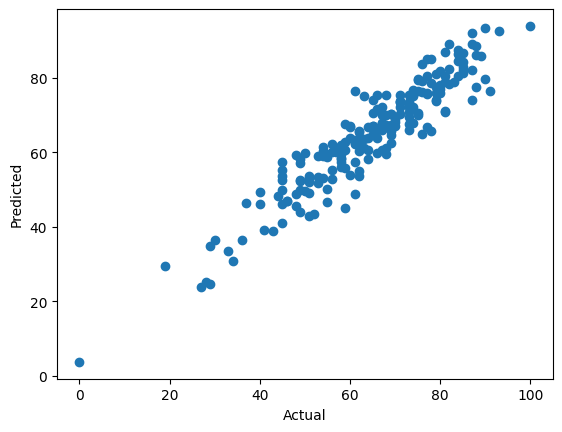

In [28]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: >

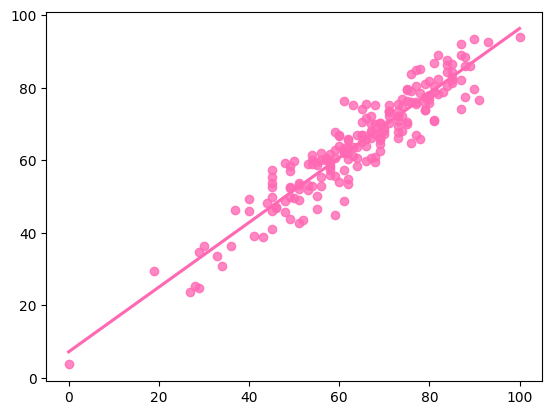

In [29]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='hotpink')

#### Difference between Actual and Predicted Values

In [30]:
pred_df = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred, 'Difference': y_test - y_pred})
pred_df

,Actual Value,Predicted Value,Difference
0,91,76.522705,14.477295
1,53,58.951172,-5.951172
2,80,76.921143,3.078857
3,74,76.796143,-2.796143
4,84,87.608154,-3.608154
...,...,...,...
195,52,43.453125,8.546875
196,62,62.070801,-0.070801
197,74,67.997314,6.002686
198,65,67.134033,-2.134033
